In [33]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from sklearn.preprocessing import MinMaxScaler
from pandas import datetime
import os
import time
import warnings
import numpy as np
from numpy import newaxis
import keras
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import pyedflib
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #Hide messy TensorFlow warnings
warnings.filterwarnings("ignore") #Hide messy Numpy warnings

# create a differenced series
def difference(dataset, interval=1):
    diff = np.zeros((dataset.shape[0],dataset.shape[1]))
    for k in range(dataset.shape[0]):
        for i in range(interval, dataset.shape[1]):
            diff[k,i] = dataset[k,i] - dataset[k,i - interval]
            
    return diff

# scale train and test data to [-1, 1]
def scale_t(data):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    data = data.reshape(-1, 1)
    #scaler = StandardScaler()
    scaler = scaler.fit(data)
    # transform data
    print(data.shape[0])
    
    data_scaled = scaler.transform(data)
    
    return scaler, data_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

def load_data(filename):
    g = pyedflib.EdfReader(filename)
    n = g.signals_in_file
    signal_labels = g.getSignalLabels()
    sig = np.zeros((n, g.getNSamples()[0]))
    for i in np.arange(n):
        len_sig = len(g.readSignal(i))
        sig[i, :len_sig] = g.readSignal(i)
    return sig
def make_data(sig, seq_len, normalise_window):
    

    data = sig[:3,:10000]
    data_scale = np.zeros(data.shape)
    for i in range(data.shape[0]):
        scaler, data_s = scale_t(data[i])
        data_scale[i] = data_s[:,0]
    if not normalise_window:
        diff = difference(data_scale,1)
    plt.plot(range(len(sig[0,:50])), sig[0,:50])
    plt.show()
    plt.plot(range(len(data_scale[0, :50])), data_scale[0, :50])
    plt.show()
    plt.plot(range(len(diff[0,:50])), diff[0,:50])
    plt.show()
    sequence_length = seq_len + 1
    
    result = np.zeros((diff.shape[0],diff.shape[1] - sequence_length, sequence_length))
    for index in range(diff.shape[1] - sequence_length):
        for k in range(diff.shape[0]):
            result[k,index] = diff[k,index: index + sequence_length]
    #print result[:,0]
    if normalise_window:
        result = normalise_windows(result)
    
    row = round(0.9 * result.shape[1])
    
    train = result[:,:int(row), :]
    test = result[:,int(row):, :]
    
    
    #print(train_scaled.shape,test_scaled.shape)  
    #print(train_scaled[0],test_scaled[0])
    #np.random.shuffle(train)
    old_x_train = train[:,:, :-1]
    y_train = train[:,:, -1]
    old_x_test = test[:,:, :-1]
    y_test = test[:,:, -1]

    x_train = np.zeros((old_x_train.shape[1], old_x_train.shape[2], old_x_train.shape[0]))
    for i in range(old_x_train.shape[1]):
        for k in range(old_x_train.shape[2]):
            vals = np.zeros(old_x_train.shape[0])
            for index in range(old_x_train.shape[0]):
                vals[index] = old_x_train[index,i,k]
                #print vals
            x_train[i,k] = vals
    
    x_test = np.zeros((old_x_test.shape[1], old_x_test.shape[2], old_x_test.shape[0]))
    for i in range(old_x_test.shape[1]):
        for k in range(old_x_test.shape[2]):
            vals = np.zeros(old_x_test.shape[0])
            for index in range(old_x_test.shape[0]):
                vals[index] = old_x_test[index,i,k]
            x_test[i,k] = vals

    return [scaler, x_train, y_train.T, x_test, y_test.T]

In [34]:
def normalise_windows(window_data):
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data
        
def build_model(layers):
    model = Sequential()
    print(layers)
    model.add(LSTM(
        input_shape=(layers[1], layers[0]),
        output_dim=layers[3],
        return_sequences=True))
    model.add(Dropout(0.2))
    
    model.add(LSTM(
        layers[2],
        return_sequences=True))
    model.add(Dropout(0.2))
    
    model.add(LSTM(
        layers[2],
        return_sequences=True))
    model.add(Dropout(0.2))
    
    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(
        output_dim=layers[3]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss='mean_absolute_error', optimizer='adagrad')
    print("> Compilation Time : ", time.time() - start)
    return model



In [35]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.acc = []
        self.val_losses = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('acc'))
        self.val_losses.append(logs.get('val_loss'))

In [36]:
def predict_point_by_point(model, data):
    #Predict each timestep given the last sequence of true data, in effect only predicting 1 step ahead each time
    predicted = model.predict(data)
    #predicted = np.reshape(predicted, (predicted.size,))
    return predicted

def predict_sequence_full(model, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted

def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of 50 steps before shifting prediction run forward by 50 steps
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

In [37]:
import time
import matplotlib.pyplot as plt

def plot_results(predicted_data, true_data, make_line):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    plt.plot(predicted_data, label='Prediction')
    plt.legend()
    if make_line:
        plt.axvline(x=y_train.shape[0] + 1, linestyle='--', color = 'b', label = 'future predicted points')
    plt.show()

def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.show()

In [38]:
global_start_time = time.time()
seq_len = 50

print('> Loading data... ')
sig = load_data('sample-data/SC4001E0-PSG.edf')




> Loading data... 


10000
10000
10000


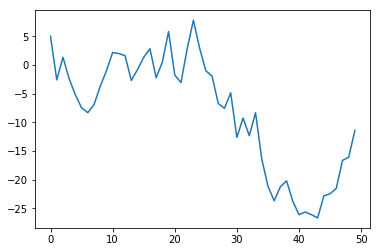

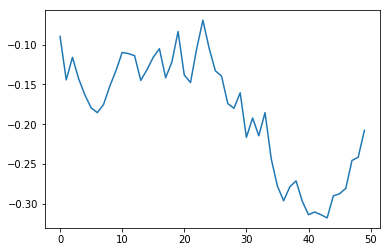

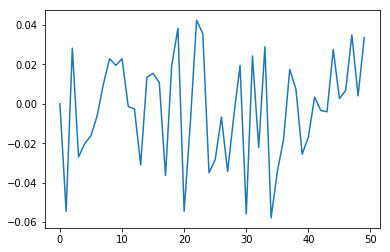

((8954, 50, 3), (8954, 3), (995, 50, 3), (995, 3))


In [39]:
scalers, X_train, y_train, X_test, y_test = make_data(sig, seq_len, False)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

In [40]:
print('> Data Loaded. Compiling...')
epochs  = 50
model = build_model([X_train.shape[2], X_train.shape[1], 100, X_train.shape[2]])
history = LossHistory()
filepath = 'save_model/weights_{epoch:02d}_sgd.hdf5'
save_model = keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=50)
#early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None)

#history = keras.callbacks.Callback()
model.fit(X_train, y_train, batch_size=800, nb_epoch=epochs, validation_split=0.05, callbacks=[history, save_model])

#predictions = lstm.predict_sequences_multiple(model, X_test, seq_len, 50)
#predicted = lstm.predict_sequence_full(model, X_test, seq_len)


> Data Loaded. Compiling...
[3, 50, 100, 3]
('> Compilation Time : ', 0.01820993423461914)
Train on 8506 samples, validate on 448 samples
Epoch 1/50


ResourceExhaustedError: OOM when allocating tensor with shape[50,800,100]
	 [[Node: lstm_15/TensorArrayStack/TensorArrayGatherV3 = TensorArrayGatherV3[_class=["loc:@lstm_15/TensorArray"], dtype=DT_FLOAT, element_shape=[?,100], _device="/job:localhost/replica:0/task:0/device:GPU:0"](lstm_15/TensorArray, lstm_15/TensorArrayStack/range, lstm_15/while/Exit_1)]]
	 [[Node: loss_3/mul/_509 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_6084_loss_3/mul", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op u'lstm_15/TensorArrayStack/TensorArrayGatherV3', defined at:
  File "/opt/conda/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/opt/conda/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/opt/conda/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/opt/conda/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/opt/conda/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/opt/conda/lib/python2.7/site-packages/tornado/ioloop.py", line 1008, in start
    self._run_callback(self._callbacks.popleft())
  File "/opt/conda/lib/python2.7/site-packages/tornado/ioloop.py", line 759, in _run_callback
    ret = callback()
  File "/opt/conda/lib/python2.7/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/opt/conda/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 536, in <lambda>
    self.io_loop.add_callback(lambda : self._handle_events(self.socket, 0))
  File "/opt/conda/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/opt/conda/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/opt/conda/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/opt/conda/lib/python2.7/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/opt/conda/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/opt/conda/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/opt/conda/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/opt/conda/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/opt/conda/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/opt/conda/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2714, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/opt/conda/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2818, in run_ast_nodes
    if self.run_code(code, result):
  File "/opt/conda/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2878, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-40-8d0ce471553d>", line 3, in <module>
    model = build_model([X_train.shape[2], X_train.shape[1], 100, X_train.shape[2]])
  File "<ipython-input-34-c661f598a6df>", line 19, in build_model
    return_sequences=True))
  File "/opt/conda/lib/python2.7/site-packages/keras/models.py", line 492, in add
    output_tensor = layer(self.outputs[0])
  File "/opt/conda/lib/python2.7/site-packages/keras/layers/recurrent.py", line 499, in __call__
    return super(RNN, self).__call__(inputs, **kwargs)
  File "/opt/conda/lib/python2.7/site-packages/keras/engine/topology.py", line 619, in __call__
    output = self.call(inputs, **kwargs)
  File "/opt/conda/lib/python2.7/site-packages/keras/layers/recurrent.py", line 2151, in call
    initial_state=initial_state)
  File "/opt/conda/lib/python2.7/site-packages/keras/layers/recurrent.py", line 608, in call
    input_length=timesteps)
  File "/opt/conda/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py", line 2772, in rnn
    outputs = output_ta.stack()
  File "/opt/conda/lib/python2.7/site-packages/tensorflow/python/ops/tensor_array_ops.py", line 335, in stack
    return self.gather(math_ops.range(0, self.size()), name=name)
  File "/opt/conda/lib/python2.7/site-packages/tensorflow/python/ops/tensor_array_ops.py", line 361, in gather
    element_shape=element_shape)
  File "/opt/conda/lib/python2.7/site-packages/tensorflow/python/ops/gen_data_flow_ops.py", line 4158, in _tensor_array_gather_v3
    flow_in=flow_in, dtype=dtype, element_shape=element_shape, name=name)
  File "/opt/conda/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/opt/conda/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/opt/conda/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[50,800,100]
	 [[Node: lstm_15/TensorArrayStack/TensorArrayGatherV3 = TensorArrayGatherV3[_class=["loc:@lstm_15/TensorArray"], dtype=DT_FLOAT, element_shape=[?,100], _device="/job:localhost/replica:0/task:0/device:GPU:0"](lstm_15/TensorArray, lstm_15/TensorArrayStack/range, lstm_15/while/Exit_1)]]
	 [[Node: loss_3/mul/_509 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_6084_loss_3/mul", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


In [ ]:
from keras.models import load_model
#model = load_model('save_model/weights_50.hdf5')

for i in range(X_train.shape[2]):
    predicted_test = predict_point_by_point(model, X_test)        
    predicted_train = predict_point_by_point(model, X_train)
    print(predicted_train.shape)
    print('Training duration (s) : ', time.time() - global_start_time)
    print predicted_test.shape
    
    plot_results(predicted_train[:50, i], y_train[:50,i], False)
    true_data = np.concatenate([y_train[:,i],y_test[:,i]])
    pred_data = np.concatenate([predicted_train[:,i],predicted_test[:,i]])
    plot_results(pred_data, true_data, True)
    plot_results(predicted_test[:50,i], y_test[:50,i], False)
    
    plt.plot(predicted_test[:50,i] - predicted_train[:50, i])

   

In [ ]:
print(X_test[:100,:,0] - X_train[:100,:,0])

In [ ]:
for layer in model.layers:
    weights = np.array(layer.get_weights())
    print weights.shape

In [ ]:
fig = plt.figure(facecolor='white')
ax = fig.add_subplot(111)
ax.plot(range(len(history.losses)),(np.array(history.losses)), label='loss')
plt.plot(range(len(history.val_losses)),(np.array(history.val_losses)), label='val loss') 
plt.legend()
plt.show()

In [ ]:
predicted = lstm.predict_sequences_multiple(model, X_test, seq_len, 50)
predicted_train = lstm.predict_sequences_multiple(model, X_train, seq_len, 50)
plot_results(predicted_train[:50], y_train[:50], False)
plot_results(np.concatenate([predicted_train,predicted]), np.concatenate([y_train,y_test]), True)
plot_results_multiple(predicted[:50], y_test[:50], 50, False)

In [ ]:
predicted = lstm.predict_sequence_full(model, X_test, seq_len)
predicted_train = lstm.predict_sequence_full(model, X_train, seq_len)

In [ ]:
Fs = 100
T = len(true_data)/Fs
N = Fs*T
    
true_data_w = np.fft.fft(true_data)/N
power_true_data = abs(true_data_w)**2

pred_data_w = np.fft.fft(pred_data)/N
power_pred_data = abs(pred_data_w)**2
w = np.arange(0,Fs,1/T)
plt.plot(w[:int(N/2)], power_true_data[:int(N/2)])
plt.ylabel('Power')
plt.xlabel('frequency (f)')
plt.title('Power spectrum')
plt.plot(w[:int(N/2)], power_pred_data[:int(N/2)])
plt.show()
plt.show()